In [39]:
import mlflow
import mlflow.pyfunc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error
import pandas as pd

data = pd.read_csv('data/us_house_Sales_data.csv')
data.head()

,Price,Address,City,Zipcode,State,Bedrooms,Bathrooms,Area (Sqft),Lot Size,Year Built,Days on Market,Property Type,MLS ID,Listing Agent,Status,Listing URL
0,"$554,217","5926 Oak Ave, San Diego, CA 65383",San Diego,65383,CA,1 bds,3 ba,772 sqft,4757 sqft,1959,101,Townhouse,Z104635,Alex Johnson - Compass,For Sale,https://www.zillow.com/homedetails/80374762_zpid/
1,"$164,454","9583 Oak Ave, Fresno, IL 79339",Fresno,79339,IL,1 bds,1 ba,2348 sqft,3615 sqft,1969,46,Apartment,Z535721,Emily Davis - Century 21,Sold,https://www.zillow.com/homedetails/86143665_zpid/
2,"$1,249,331","8224 Oak Ave, Sacramento, TX 87393",Sacramento,87393,TX,6 bds,1 ba,3630 sqft,9369 sqft,1990,59,Townhouse,Z900458,Mike Lee - Coldwell Banker,For Sale,https://www.zillow.com/homedetails/37082403_zpid/
3,"$189,267","232 Oak Ave, Fresno, TX 38666",Fresno,38666,TX,2 bds,1 ba,605 sqft,8804 sqft,1958,119,Apartment,Z318589,John Doe - RE/MAX,Pending,https://www.zillow.com/homedetails/39318132_zpid/
4,"$465,778","5446 Pine Rd, Los Angeles, CA 23989",Los Angeles,23989,CA,3 bds,2 ba,1711 sqft,9260 sqft,2020,26,Townhouse,Z899716,John Doe - RE/MAX,Pending,https://www.zillow.com/homedetails/22454634_zpid/


In [40]:
# Cleaning the data
data['Price'] = data['Price'].replace(r'[\$,]','',regex=True).astype(int)
data.drop(columns=['Address', 'MLS ID', 'Listing URL'], axis=1, inplace=True)

label_encoders = {}
for col in ['City', 'State', 'Property Type', 'Listing Agent', 'Status']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le # Stores this in the label_encoders dict earlier

data['Bedrooms'] = data['Bedrooms'].str.extract(r'(\d+)').astype(int)
data['Bathrooms'] = data['Bathrooms'].str.extract(r'(\d+)').astype(int)

for col in ['Area (Sqft)', 'Lot Size']:
    data[col] = data[col].str.replace('sqft', '').str.replace(',','').str.extract(r'(\d+)').astype(int)

data.head()

,Price,City,Zipcode,State,Bedrooms,Bathrooms,Area (Sqft),Lot Size,Year Built,Days on Market,Property Type,Listing Agent,Status
0,554217,3,65383,0,1,3,772,4757,1959,101,4,0,0
1,164454,0,79339,2,1,1,2348,3615,1969,46,0,1,2
2,1249331,2,87393,4,6,1,3630,9369,1990,59,4,4,0
3,189267,0,38666,4,2,1,605,8804,1958,119,0,3,1
4,465778,1,23989,0,3,2,1711,9260,2020,26,4,3,1


In [41]:
len(data.columns)

13

In [42]:
# Encoding zipcode based on the target variable 'Price', which will lead to data leakage, but oh well
data['Zipcode_encoded'] = data.groupby('Zipcode')['Price'].transform('mean')
data.drop(columns=['Zipcode'], axis = 1, inplace=True)

data.head()

,Price,City,State,Bedrooms,Bathrooms,Area (Sqft),Lot Size,Year Built,Days on Market,Property Type,Listing Agent,Status,Zipcode_encoded
0,554217,3,0,1,3,772,4757,1959,101,4,0,0,554217.0
1,164454,0,2,1,1,2348,3615,1969,46,0,1,2,164454.0
2,1249331,2,4,6,1,3630,9369,1990,59,4,4,0,1249331.0
3,189267,0,4,2,1,605,8804,1958,119,0,3,1,189267.0
4,465778,1,0,3,2,1711,9260,2020,26,4,3,1,465778.0


In [55]:
temp = pd.read_csv("data/us_house_Sales_data.csv")
data["MLS ID"] = temp["MLS ID"].str[1:].astype(int)
# data.to_csv("house_data.csv", index=False)
start_date = pd.to_datetime("2015-01-01")
end_date = start_date + pd.Timedelta(days=2999)
data["datetime"] = pd.date_range(start=start_date, end=end_date, freq="D")
data.to_parquet("house_data.parquet", index=False)

In [56]:
pd.read_parquet("house_data.parquet")

,Price,City,State,Bedrooms,Bathrooms,Area (Sqft),Lot Size,Year Built,Days on Market,Property Type,Listing Agent,Status,Zipcode_encoded,MLS ID,datetime
0,554217,3,0,1,3,772,4757,1959,101,4,0,0,554217.0,104635,2015-01-01
1,164454,0,2,1,1,2348,3615,1969,46,0,1,2,164454.0,535721,2015-01-02
2,1249331,2,4,6,1,3630,9369,1990,59,4,4,0,1249331.0,900458,2015-01-03
3,189267,0,4,2,1,605,8804,1958,119,0,3,1,189267.0,318589,2015-01-04
4,465778,1,0,3,2,1711,9260,2020,26,4,3,1,465778.0,899716,2015-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,801824,3,4,3,4,3318,6745,2022,61,2,1,2,801824.0,284935,2023-03-15
2996,843703,2,0,6,2,900,8046,2012,64,2,1,2,843703.0,842214,2023-03-16
2997,743513,0,4,4,3,2921,2041,2005,48,2,2,2,743513.0,350999,2023-03-17
2998,211664,3,4,2,4,701,1344,2017,117,3,0,1,211664.0,748192,2023-03-18


In [45]:
X = data.drop(columns = ['Price'], axis = 1)
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state= 42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

print(rmse)

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>)

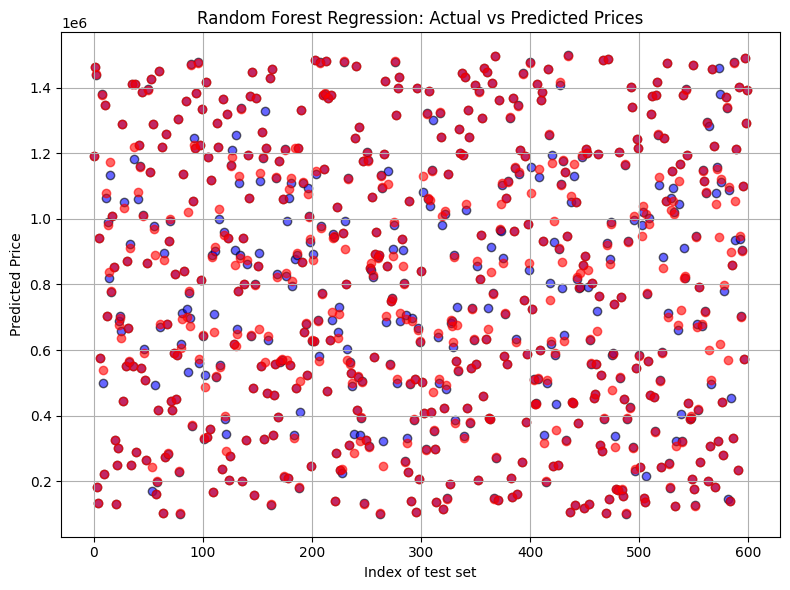

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(range(len(X_test)), y_test, alpha=0.6, color='blue', edgecolors='k')
plt.scatter(range(len(X_test)), y_pred, alpha=.6, color='red')
plt.xlabel('Index of test set')
plt.ylabel('Predicted Price')
plt.title('Random Forest Regression: Actual vs Predicted Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from feast import FeatureStore
import pandas as pd

# Initialize store (repo_path points to the directory with feature_store.yaml)
store = FeatureStore(repo_path="experiment/.")

In [ ]:
entity_rows = [
    {"MLS_ID": 104635},   # Must match the join_keys in your Entity definition
    {"MLS_ID": 535721},
]

features = store.get_online_features(
    features=[
        "housing_features:Price",
        "housing_features:Bedrooms",
        "housing_features:Zipcode_encoded"
    ],
    entity_rows=entity_rows
).to_df()

features.head()

/opt/anaconda3/envs/deployml/lib/python3.11/site-packages/feast/utils.py:1253: UserWarning: Using entity name is deprecated. Use join_key instead.
  warnings.warn("Using entity name is deprecated. Use join_key instead.")


,MLS ID,Zipcode_encoded,Price,Bedrooms
0,104635,None,None,None
1,535721,None,None,None


In [57]:
import sqlite3
import pandas as pd
con = sqlite3.connect("data/online_store.db")
print("\n--- Schema of online store ---")
print(
    pd.read_sql_query(
        "SELECT * FROM deployml2025_housing_features", con).columns.tolist())
con.close()


--- Schema of online store ---


DatabaseError: Execution failed on sql 'SELECT * FROM deployml2025_housing_features': no such table: deployml2025_housing_features

In [61]:
from feast import FeatureStore

store = FeatureStore(repo_path="experiment")

features = store.get_online_features(
    features=[
        "housing_features:Price",
        "housing_features:Bedrooms"
    ],
    entity_rows=[{"MLS ID": 104635}]
).to_df()

print(features)

   MLS ID Price Bedrooms
0  104635  None     None


In [66]:
parquet = pd.read_parquet('experiment/upright_octopus/feature_repo/data/driver_stats.parquet').head()
parquet.dtypes

event_timestamp    datetime64[ns, UTC]
driver_id                        int64
conv_rate                      float32
acc_rate                       float32
avg_daily_trips                  int32
created                 datetime64[us]
dtype: object